In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

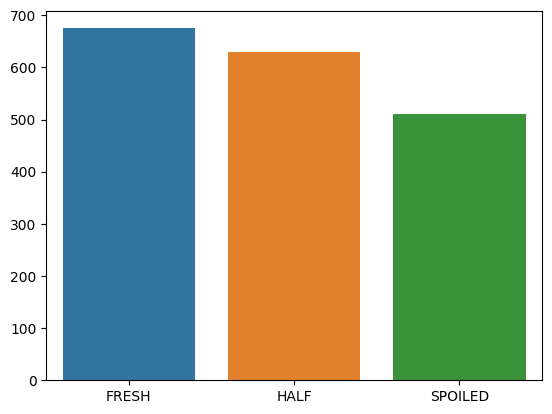

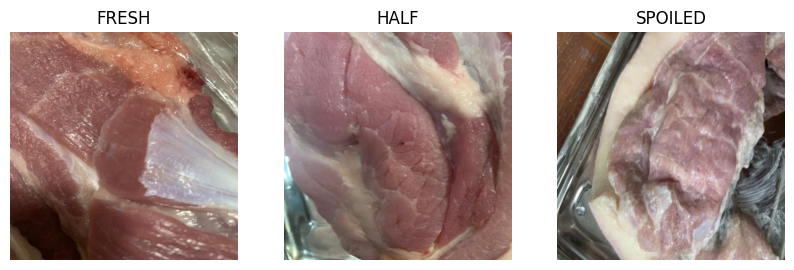

In [ ]:
# Set directory where the images are stored
data_dir = "/content/drive/MyDrive/Meat Freshness.v1-new-dataset.multiclass/train"

# Create a list of all image file names
file_names = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]

# Create a dictionary to count the number of images in each class
class_counts = {"FRESH": 0, "HALF": 0, "SPOILED": 0}

# Create a dictionary to store a sample image from each class
sample_images = {"FRESH": None, "HALF": None, "SPOILED": None}

# Loop through all images and count the number of images in each class
for file_name in file_names:
    img_class = file_name.split("-")[0]
    class_counts[img_class] += 1

    # If we haven't already stored a sample image for this class, store one now
    if sample_images[img_class] is None:
        img = Image.open(os.path.join(data_dir, file_name))
        sample_images[img_class] = img

# Plot a bar chart to visualize the distribution of image classes
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))

# Display a sample image from each class
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

for i, img_class in enumerate(sample_images):
    axes[i].imshow(sample_images[img_class])
    axes[i].axis("off")
    axes[i].set_title(img_class)

plt.show()

###The 3 classes (Fresh, Half-Fresh and Spoiled) seem to be quite balanced in the training dataset.###

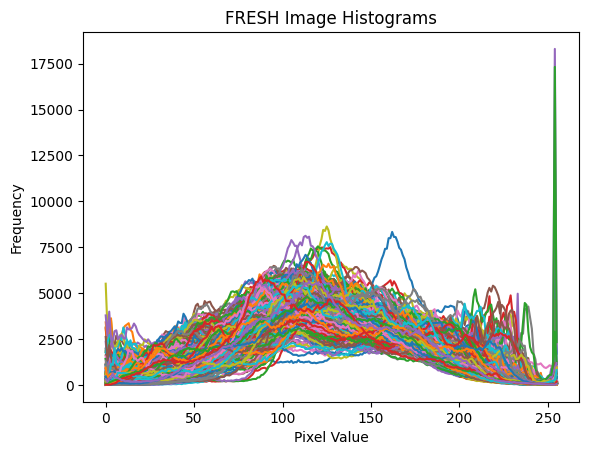

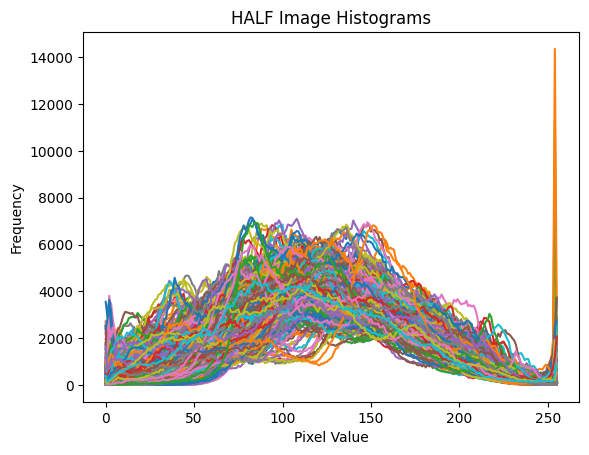

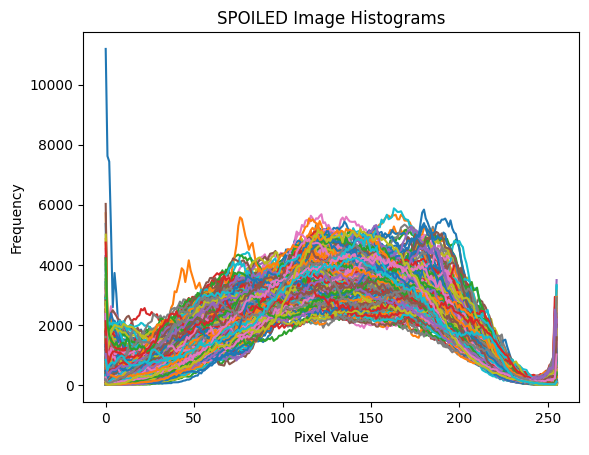

In [ ]:
# Set directory where the images are stored
data_dir = "/content/drive/MyDrive/Meat Freshness.v1-new-dataset.multiclass/train"

# Create a list of all image file names
file_names = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]

# Create a dictionary to store the histograms for each class
histograms = {"FRESH": [], "HALF": [], "SPOILED": []}

# Loop through all images and calculate the histogram for each class
for file_name in file_names:
    img_class = file_name.split("-")[0]
    img_path = os.path.join(data_dir, file_name)
    try:
        img = Image.open(img_path)
    except:
        continue  # Skip non-image files
    hist, _ = np.histogram(img, bins=256, range=(0, 255))
    histograms[img_class].append(hist)

# Plot the histograms for each class
for img_class in histograms:
    plt.figure()
    plt.title(f"{img_class} Image Histograms")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    for hist in histograms[img_class]:
        plt.plot(hist)
    plt.show()

###It's quite interesting to note that distribution of frequency of pixels from darker (0) to lighter (255) are different for fresh to spoiled. The frequency of lighter pixels are more concentrated for fresh meat and the frequency of darker pixels are higher for spoiled meat. The frequency distribution of spoiled meats have a different distribution that seems to be more normally distributed.### 

In [ ]:
#Augmentation of the images

from torchvision import transforms

# Define the transforms for the training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the transform for the validation data
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#Try the augmentation

import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset

class MeatDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.data_dir, file_name)
        img_class = file_name.split("-")[0]

        # Load the image
        img = Image.open(img_path)

        # Apply the transforms
        if self.transform:
            img = self.transform(img)

        # Convert the class label to a tensor
        label = torch.tensor([0, 0, 0], dtype=torch.float32)
        if img_class == "FRESH":
            label = torch.tensor([1, 0, 0], dtype=torch.float32)
        elif img_class == "HALF":
            label = torch.tensor([0, 1, 0], dtype=torch.float32)
        elif img_class == "SPOILED":
            label = torch.tensor([0, 0, 1], dtype=torch.float32)

        return img, label

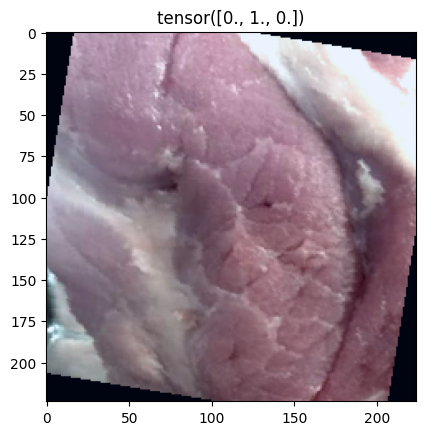

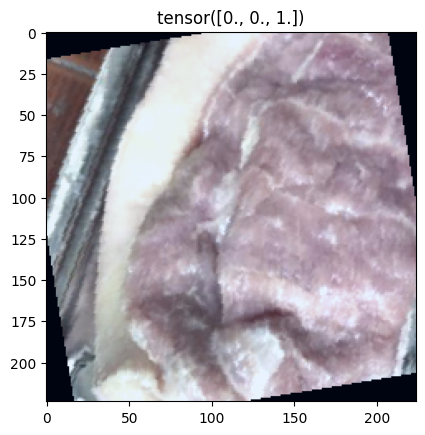

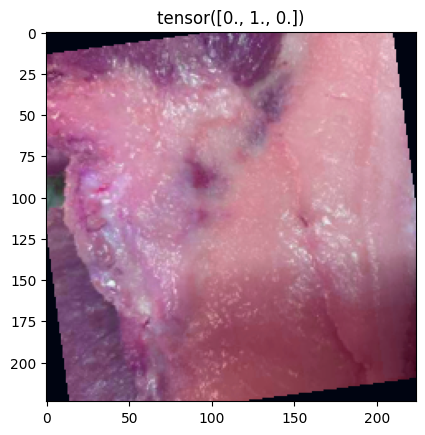

In [ ]:
# Create the train and validation datasets
train_dataset = MeatDataset(data_dir, transform=train_transform)
val_dataset = MeatDataset(data_dir, transform=val_transform)

# Create the train and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Display a few sample images
for i in range(3):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0) # Convert the tensor to a PIL image
    img = (img - img.min()) / (img.max() - img.min()) # Normalize the pixel values to [0, 1]
    plt.imshow(img)
    plt.title(label)
    plt.show()

###Above are just samples of some of the images that have been augmented by the pipeline.###